In [52]:
# Lab 04 (2 hrs) – End-to-End Regression
# Learning Outcomes
# By the end of this lab, students will be able to:
# 1. Preprocess numerical features for regression.
# 2. Train and evaluate linear, multiple, and polynomial regression models.
# 3. Compare manual vs library-based implementations.
# P — Project
# • Data cleaning (handle NAs, scaling if needed).
# • Train/test split.
# • Fit:
# 1. Simple linear regression (manual).
# 2. Multiple linear regression (sklearn).
# 3. Polynomial regression.
# • Evaluate with MSE, RMSE, R2.
# • Save plots &amp; results table.
# Resources
# • Scikit-learn Model Evaluation – https://scikitlearn.
# org/stable/modules/model_evaluation.html

In [53]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Output directories
out_dir = Path("LabAssig4_stuff")
plots_dir = out_dir / "plots"
out_dir.mkdir(parents=True, exist_ok=True)
plots_dir.mkdir(parents=True, exist_ok=True)


In [54]:
# Cell 2: Load cleaned Titanic-like data
csv_path = "LabAssig2_cleanTitanicCSV.csv"  # given path name
df = pd.read_csv(csv_path)

print(df.shape)
df.head()


(889, 16)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,embark_town,alive,alone,age_was_missing,fare_capped
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,Southampton,no,False,0,7.2500
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,Cherbourg,yes,False,0,65.6563
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,Southampton,yes,True,0,7.9250
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,Southampton,yes,False,0,53.1000
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,Southampton,no,True,0,8.0500


In [55]:
# Cell 3: Define target and features
# For regression demo, predict 'fare' from other columns.
target_col = "fare"
y = df[target_col].values

# Drop target and any known leakage columns if necessary. Keep both numeric and categorical features.
X = df.drop(columns=[target_col])

# Identify numeric vs categorical columns from the provided schema
numeric_cols = [
    # numeric-like in the sample
    "age", "sibsp", "parch", "pclass", "survived", "alone", "adult_male",
    "age_was_missing", "fare_capped"
]
numeric_cols = [c for c in numeric_cols if c in X.columns]

categorical_cols = [
    "sex", "embarked", "class", "who", "embark_town", "alive"
]
categorical_cols = [c for c in categorical_cols if c in X.columns]

print("Numeric:", numeric_cols)
print("Categorical:", categorical_cols)

# Train/test split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Numeric: ['age', 'sibsp', 'parch', 'pclass', 'survived', 'alone', 'adult_male', 'age_was_missing', 'fare_capped']
Categorical: ['sex', 'embarked', 'class', 'who', 'embark_town', 'alive']


In [56]:
# Cell 4: Build a reusable preprocessing transformer
# - Standard scale numeric features
# - One-hot encode categorical features
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="drop"
)


In [57]:
# Cell 5: Simple Linear Regression (manual) on a single chosen numeric feature -> predict fare
# Choose a single numeric predictor with reasonable relation to fare; use 'pclass' or 'age' or 'survived'.
# Here we use 'pclass' (lower class -> lower fare on average).
single_feature = "pclass"
assert single_feature in X.columns, f"{single_feature} not in dataframe."

# Extract the single feature arrays for train/test
x_train = X_train_raw[[single_feature]].values.astype(float).ravel()
x_test  = X_test_raw[[single_feature]].values.astype(float).ravel()

# Compute coefficients via closed-form (simple linear regression)
# beta1 = cov(x,y)/var(x); beta0 = ybar - beta1 * xbar
x_bar = x_train.mean()
y_bar = y_train.mean()
beta1 = np.sum((x_train - x_bar) * (y_train - y_bar)) / np.sum((x_train - x_bar)**2)
beta0 = y_bar - beta1 * x_bar

# Predict
y_pred_manual_train = beta0 + beta1 * x_train
y_pred_manual_test  = beta0 + beta1 * x_test

# Evaluate
mse_manual = mean_squared_error(y_test, y_pred_manual_test)
rmse_manual = np.sqrt(mse_manual)
r2_manual = r2_score(y_test, y_pred_manual_test)

print({"beta0": beta0, "beta1": beta1, "MSE": mse_manual, "RMSE": rmse_manual, "R2": r2_manual})


{'beta0': 106.92931539909918, 'beta1': -32.24217519609904, 'MSE': 1858.5056465595874, 'RMSE': 43.11038907919514, 'R2': 0.30339396869555646}


In [58]:
# Cell 6: Plot manual simple regression fit on train data
plt.figure(figsize=(6,4))
plt.scatter(x_train, y_train, alpha=0.5, label="Train data")
x_line = np.linspace(x_train.min(), x_train.max(), 200)
y_line = beta0 + beta1 * x_line
plt.plot(x_line, y_line, color="red", label="Manual fit")
plt.xlabel(single_feature)
plt.ylabel("fare")
plt.title(f"Manual Simple Linear Regression: {single_feature} -> fare")
plt.legend()
plot_path = plots_dir / f"manual_simple_lr_{single_feature}_fare.png"
plt.tight_layout()
plt.savefig(plot_path, dpi=150)
plt.close()

plot_path


PosixPath('LabAssig4_stuff/plots/manual_simple_lr_pclass_fare.png')

In [59]:
# Cell 7: Multiple Linear Regression with preprocessing
multi_lr = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("regressor", LinearRegression())
])

multi_lr.fit(X_train_raw, y_train)
y_pred_multi_test = multi_lr.predict(X_test_raw)

mse_multi = mean_squared_error(y_test, y_pred_multi_test)
rmse_multi = np.sqrt(mse_multi)
r2_multi = r2_score(y_test, y_pred_multi_test)

print({"MSE": mse_multi, "RMSE": rmse_multi, "R2": r2_multi})


{'MSE': 1286.7487224331503, 'RMSE': 35.87127991071897, 'R2': 0.5177001896768352}


In [60]:
# Cell 8: Polynomial Regression using PolynomialFeatures on a selected numeric subset
# Strategy: apply preprocessing to numeric columns only for polynomial expansion, while still one-hot encoding categoricals.
# Create a separate ColumnTransformer for polynomial path: Polynomial on numeric, OneHot on categoricals, then LinearRegression.

poly_degree = 2  # adjust as needed
poly_numeric = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=poly_degree, include_bias=False))
])

poly_preprocessor = ColumnTransformer(
    transformers=[
        ("num_poly", poly_numeric, numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
    ],
    remainder="drop"
)

poly_lr = Pipeline(steps=[
    ("preprocess", poly_preprocessor),
    ("regressor", LinearRegression())
])

poly_lr.fit(X_train_raw, y_train)
y_pred_poly_test = poly_lr.predict(X_test_raw)

mse_poly = mean_squared_error(y_test, y_pred_poly_test)
rmse_poly = np.sqrt(mse_poly)
r2_poly = r2_score(y_test, y_pred_poly_test)

print({"degree": poly_degree, "MSE": mse_poly, "RMSE": rmse_poly, "R2": r2_poly})


{'degree': 2, 'MSE': 1164.6115505892035, 'RMSE': 34.12640547419554, 'R2': 0.5634797065217052}


In [61]:
# Cell 9: Optional diagnostic plot for polynomial model vs predictions (parity plot)
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_poly_test, alpha=0.5)
lims = [min(y_test.min(), y_pred_poly_test.min()), max(y_test.max(), y_pred_poly_test.max())]
plt.plot(lims, lims, "r--", label="Ideal")
plt.xlabel("True fare")
plt.ylabel("Predicted fare")
plt.title(f"Polynomial Regression (degree={poly_degree}) - Parity Plot")
plt.legend()
poly_plot_path = plots_dir / f"poly_parity_deg{poly_degree}.png"
plt.tight_layout()
plt.savefig(poly_plot_path, dpi=150)
plt.close()

poly_plot_path


PosixPath('LabAssig4_stuff/plots/poly_parity_deg2.png')

In [62]:
# Cell 10: Aggregate metrics and save table
results = pd.DataFrame([
    {"model": f"manual_simple_lr({single_feature})", "MSE": mse_manual, "RMSE": rmse_manual, "R2": r2_manual},
    {"model": "multiple_lr_sklearn", "MSE": mse_multi, "RMSE": rmse_multi, "R2": r2_multi},
    {"model": f"polynomial_lr_deg{poly_degree}", "MSE": mse_poly, "RMSE": rmse_poly, "R2": r2_poly},
])

results_path = out_dir / "regression_results.csv"
results.to_csv(results_path, index=False)
results


,model,MSE,RMSE,R2
0,manual_simple_lr(pclass),1858.505647,43.110389,0.303394
1,multiple_lr_sklearn,1286.748722,35.871280,0.517700
2,polynomial_lr_deg2,1164.611551,34.126405,0.563480


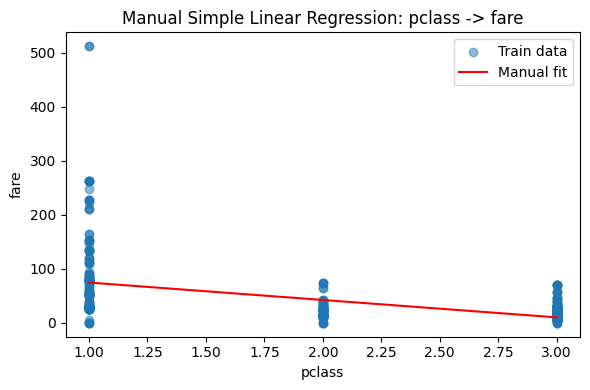

In [63]:
# New Cell A: Show manual simple regression fit inline (keeps file save)
plt.figure(figsize=(6,4))
plt.scatter(x_train, y_train, alpha=0.5, label="Train data")
x_line = np.linspace(x_train.min(), x_train.max(), 200)
y_line = beta0 + beta1 * x_line
plt.plot(x_line, y_line, color="red", label="Manual fit")
plt.xlabel(single_feature)
plt.ylabel("fare")
plt.title(f"Manual Simple Linear Regression: {single_feature} -> fare")
plt.legend()
plot_path = plots_dir / f"manual_simple_lr_{single_feature}_fare.png"
plt.tight_layout()
plt.savefig(plot_path, dpi=150)
plt.show()  # inline display


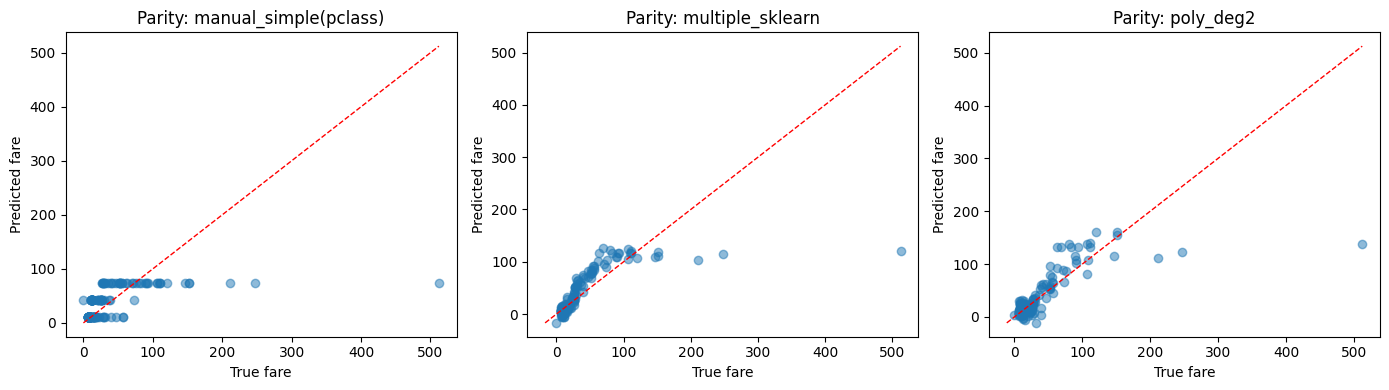

In [64]:
# New Cell B: Parity (y_true vs y_pred) for all models
preds = {
    f"manual_simple({single_feature})": y_pred_manual_test,
    "multiple_sklearn": y_pred_multi_test,
    f"poly_deg{poly_degree}": y_pred_poly_test,
}

fig, axes = plt.subplots(1, 3, figsize=(14,4), sharex=False, sharey=False)
for ax, (name, yp) in zip(axes, preds.items()):
    ax.scatter(y_test, yp, alpha=0.5)
    lims = [min(y_test.min(), yp.min()), max(y_test.max(), yp.max())]
    ax.plot(lims, lims, "r--", linewidth=1)
    ax.set_title(f"Parity: {name}")
    ax.set_xlabel("True fare")
    ax.set_ylabel("Predicted fare")
plt.tight_layout()
plt.show()


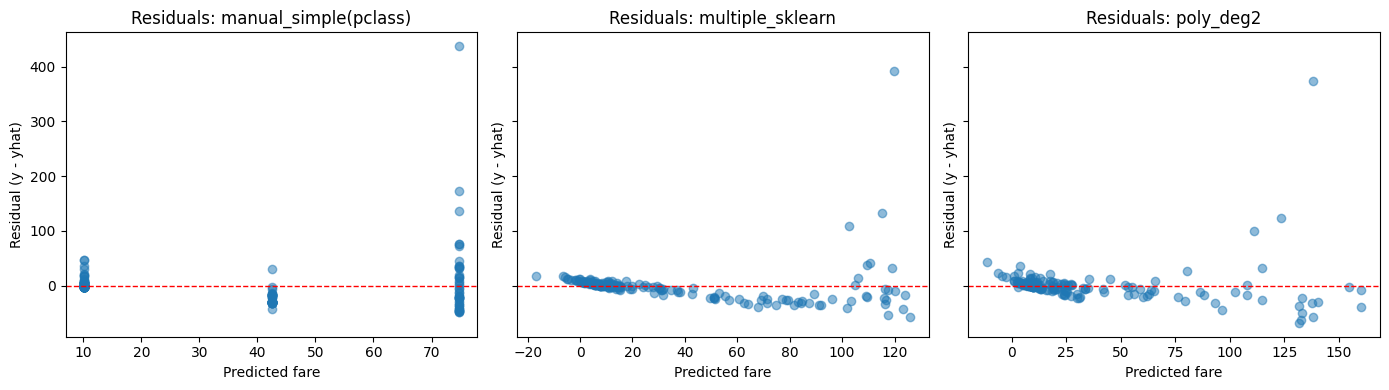

In [65]:
# New Cell C: Residual plots (residual = y_true - y_pred)
fig, axes = plt.subplots(1, 3, figsize=(14,4), sharex=False, sharey=True)
for ax, (name, yp) in zip(axes, preds.items()):
    residuals = y_test - yp
    ax.scatter(yp, residuals, alpha=0.5)
    ax.axhline(0, color="red", linestyle="--", linewidth=1)
    ax.set_title(f"Residuals: {name}")
    ax.set_xlabel("Predicted fare")
    ax.set_ylabel("Residual (y - yhat)")
plt.tight_layout()
plt.show()


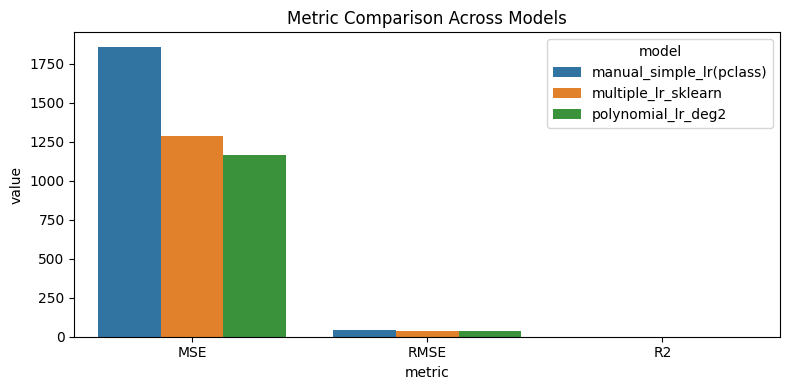

In [66]:
# New Cell D: Bar chart comparing MSE, RMSE, R2
import seaborn as sns

results_long = results.melt(id_vars=["model"], value_vars=["MSE", "RMSE", "R2"],
                            var_name="metric", value_name="value")

plt.figure(figsize=(8,4))
sns.barplot(data=results_long, x="metric", y="value", hue="model")
plt.title("Metric Comparison Across Models")
plt.tight_layout()
plt.show()


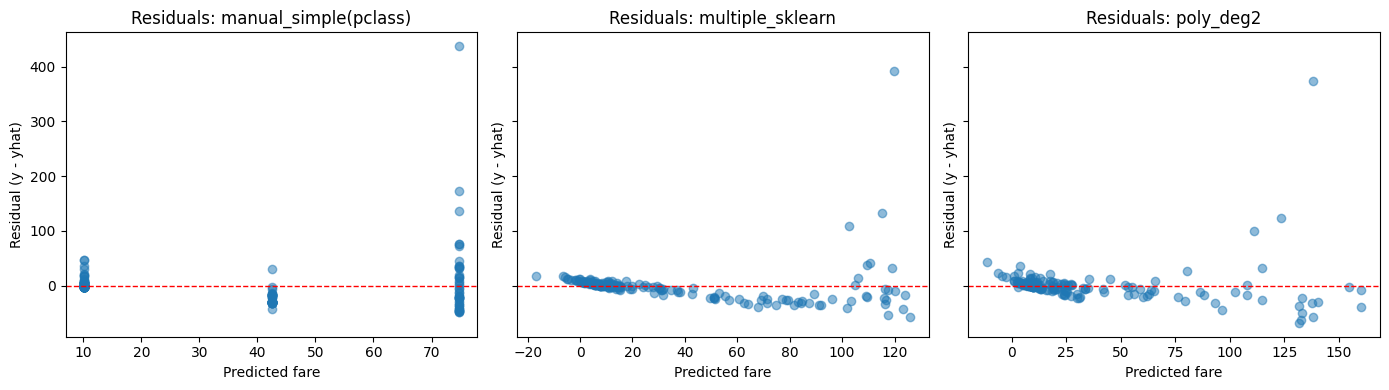

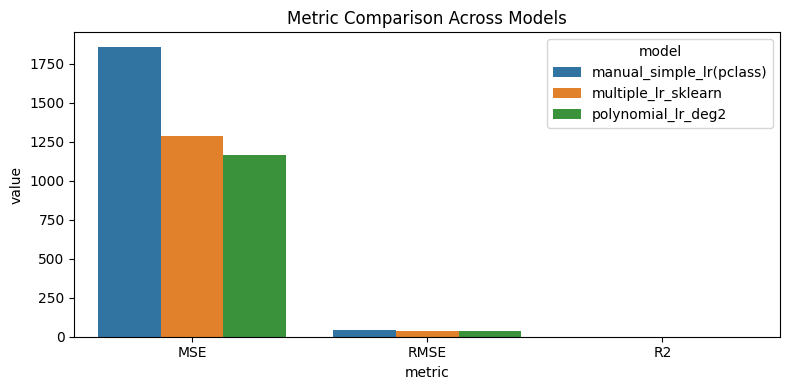

In [67]:
# New Cell E: Save the comparison figures as files
# Re-run the plotting code but saving each before show/close, or capture current fig via gcf().
# Example for residuals/chart:
fig_resid, axes = plt.subplots(1, 3, figsize=(14,4), sharex=False, sharey=True)
for ax, (name, yp) in zip(axes, preds.items()):
    residuals = y_test - yp
    ax.scatter(yp, residuals, alpha=0.5)
    ax.axhline(0, color="red", linestyle="--", linewidth=1)
    ax.set_title(f"Residuals: {name}")
    ax.set_xlabel("Predicted fare")
    ax.set_ylabel("Residual (y - yhat)")
fig_resid.tight_layout()
resid_path = plots_dir / "residuals_all_models.png"
fig_resid.savefig(resid_path, dpi=150)
plt.show()

fig_bar = plt.figure(figsize=(8,4))
sns.barplot(data=results_long, x="metric", y="value", hue="model")
plt.title("Metric Comparison Across Models")
plt.tight_layout()
bar_path = plots_dir / "metrics_comparison_bar.png"
plt.savefig(bar_path, dpi=150)
plt.show()
